## Подготовка и среда

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

from stonks.paper_testing.LearningEnvironment import LearningEnvironment
from stonks.paper_testing import Emulator

import abc
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver, dynamic_episode_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [2]:
balance = {'usdt': 100, 'btc': 0}

emu = Emulator(string_start='../', fee=0.0)

train_py_env = LearningEnvironment(emu, balance, string_start='../', test_time=3600, orderbook_depth=1, 
                                  pair_list=['btcusdt'], asset_list=['btc', 'usdt'])
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

eval_py_env = LearningEnvironment(emu, balance, string_start='../', test_time=3600, orderbook_depth=1,
                                 start_time=1581434096 + 3600, reset=False,
                                 pair_list=['btcusdt'], asset_list=['btc', 'usdt'])
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Модель

In [3]:
fc_layer_params = (64, 32, 16)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

W0504 19:39:08.623626 140574741325632 base_layer.py:1790] Layer QNetwork is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W0504 19:39:08.664195 140574741325632 base_layer.py:1790] Layer TargetQNetwork is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defa

In [4]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

## Replay buffer и драйвер

In [5]:
replay_buffer_capacity = 100000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=agent.collect_data_spec,
        batch_size=train_env.batch_size,
        max_length=replay_buffer_capacity)

replay_observer = [replay_buffer.add_batch]

In [6]:
batch_size = 32

dataset = replay_buffer.as_dataset(
            num_parallel_calls=3,
            sample_batch_size=batch_size,
            num_steps=2).prefetch(3)
    
iterator = iter(dataset)

In [7]:
train_metrics = [tf_metrics.AverageReturnMetric(), tf_metrics.EnvironmentSteps(), tf_metrics.NumberOfEpisodes()]

driver = dynamic_step_driver.DynamicStepDriver(
            train_env,
            collect_policy,
            observers=replay_observer + train_metrics,
            num_steps=1)

Тест на случайной модели:

In [8]:
train_env.reset()
try_metrics = [tf_metrics.AverageReturnMetric(), tf_metrics.EnvironmentSteps()]
try_driver = dynamic_episode_driver.DynamicEpisodeDriver(train_env, random_policy, observers=try_metrics)

_ = try_driver.run()
print(f'Изменение баланса: {try_metrics[0].result().numpy()}')
print(f'Число шагов: {try_metrics[1].result().numpy()}')

Изменение баланса: -1.5906981229782104
Число шагов: 3599


In [9]:
eval_env.reset()
try_metrics = [tf_metrics.AverageReturnMetric(), tf_metrics.EnvironmentSteps()]
try_driver = dynamic_episode_driver.DynamicEpisodeDriver(eval_env, random_policy, observers=try_metrics)

_ = try_driver.run()
print(f'Изменение баланса: {try_metrics[0].result().numpy()}')
print(f'Число шагов: {try_metrics[1].result().numpy()}')

Изменение баланса: -1.4005779027938843
Число шагов: 3599


## Обучение

In [10]:
# Сразу насыпем в буфер немного всего

init_driver = dynamic_episode_driver.DynamicEpisodeDriver(
            train_env,
            collect_policy,
            observers=replay_observer)
_ = init_driver.run()

In [11]:
from tqdm import tqdm_notebook

num_iterations = 1000000
log_interval = 10000

losses = []
train_returns = []
eval_returns = []
eval_metrics = [tf_metrics.AverageReturnMetric()]

train_driver = dynamic_episode_driver.DynamicEpisodeDriver(
            train_env,
            agent.policy,
            observers=eval_metrics)

eval_driver = dynamic_episode_driver.DynamicEpisodeDriver(
            eval_env,
            agent.policy,
            observers=eval_metrics)

agent.train_step_counter.assign(0)

for metric in train_metrics:
    metric.reset()

try:
    for _ in tqdm_notebook(range(num_iterations)):
        time_step, _ = driver.run()
        experience, _ = next(iterator)

        train_loss = agent.train(experience)
        step = agent.train_step_counter.numpy()

        if step % log_interval == 0:
            losses.append(train_loss.loss.numpy())
            train_env.reset()
            eval_env.reset()
            eval_metrics[0].reset()
            _ = train_driver.run()
            train_return = eval_metrics[0].result().numpy()
            eval_metrics[0].reset()
            _ = eval_driver.run()
            eval_return = eval_metrics[0].result().numpy()

            train_returns.append(train_return)
            eval_returns.append(eval_return)

            print(f'{step} - Return на обучении: {train_return}, на валидации: {eval_return}')
except KeyboardInterrupt:
    print('Interruption!')

10000 - Return на обучении: 0.0, на валидации: 0.0


InvalidArgumentError: Loss is inf or nan : Tensor had NaN values [Op:CheckNumerics]

In [ ]:
utils.val

In [13]:
checkpoint_dir = './checkpoint'
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer
)

## Сравнение со случайной моделью

In [38]:
def custom_driver(policy, env):
    step = env.reset()
    actions = []

    while not step.is_last():
        action = policy.action(step)
        actions.append(action)
        step = env.step(action)
    history = env.pyenv.envs[0].history
    print(f'Итоговый баланс: {history[-1][1]}')
    plt.plot(range(len(history)), [el[1] for el in history])
    return actions

Итоговый баланс: 98.37064953999997


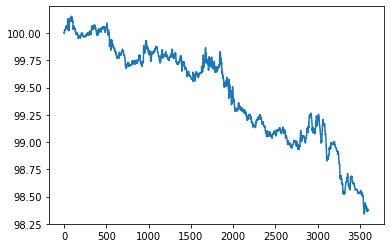

In [39]:
actions = custom_driver(random_policy, train_env)

Итоговый баланс: 100.0


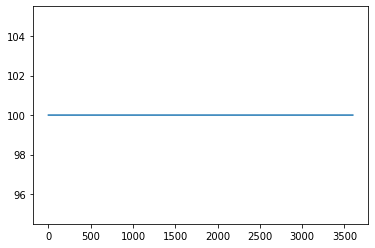

In [43]:
actions = custom_driver(eval_policy, train_env)

Итоговый баланс: 103.23685119999999


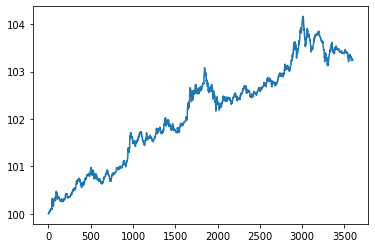

In [41]:
class BtcPolicy:
    def __init__(self):
        pass
    def action(self, step):
        return 0

    
btc = BtcPolicy()
actions = custom_driver(btc, train_env)